In [3]:
#| default_exp game

# Game

> Easily analyze a single game of pickleball

In [2]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [3]:
#| export
from pklshop.data import *
from pklshop.stats import *
from pklshop.name import *
import pandas as pd

In [4]:
#! Need to think about how to store these tables so that functions can use them
#! but don't want to have to pass specific tables every time
rally = get_tab_as_df("rally")
players = get_tab_as_df("player")
game = get_tab_as_df("game")
team = get_tab_as_df("team")
match = get_tab_as_df("match")
tournament = get_tab_as_df("tournament") 

The Game class is a convienient representation of a single pickleball game. It will calculate basic stats for each player.

In [129]:
#| export
class Game:
    """
    A class to represent a game of pickleball.
    """
    def __init__(self, game_id:str):
        #Create dfs for this game
        self.game_id = game_id
        self.rally = rally[rally.game_id == game_id]
        self.num_rallies = len(self.rally)
        self.game = game[game.game_id == game_id]

        #get the teams and players for this game
        self.w_team_id = self.game[self.game.game_id == self.game_id].w_team_id.values[0]
        self.l_team_id = self.game[self.game.game_id == self.game_id].l_team_id.values[0]
        self.team = team[team.team_id.isin([self.w_team_id, self.l_team_id])]
        self.p1, self.p2 = self.team[self.team.team_id == self.w_team_id].player_id.values #winning players are p1 and p2
        self.p3, self.p4 = self.team[self.team.team_id == self.l_team_id].player_id.values #losing team are p3 and p4

        self.players = players[players.player_id.isin([self.p1, self.p2, self.p3, self.p4])]
        
        self.w_team_name = get_team_name(self.w_team_id, self.team)
        self.l_team_name = get_team_name(self.l_team_id, self.team)

        #get the scores
        self.score_w = self.game[self.game.game_id == self.game_id].score_w.values[0]
        self.score_l = self.game[self.game.game_id == self.game_id].score_l.values[0]

    def __str__(self):
        return "Game({})".format(self.game_id)
    __repr__ = __str__

    def get_error_rate(self, player_id:str):
        """
        Returns the error rate for a given player in a game.
        """
        num_unforced_errors = sum((self.rally.ending_player_id == player_id) & ((self.rally.ending_type == 'Unforced Error') | (self.rally.ending_type == 'Error')))
        return num_unforced_errors/self.num_rallies
    
    def get_winners_rate(self, player_id:str):
        """
        Returns the number of winners for a given player in a game.
        """
        return sum((self.rally.ending_player_id == player_id) & (self.rally.ending_type == 'Winner'))/self.num_rallies

    def first_serve_team(self):
        '''
        Returns the team_id of the team that served first for a given game with game_id.
        '''
        return self.rally[self.rally.rally_nbr == 1].srv_team_id.values[0]

    def first_serve_team_name(self):
        '''
        Returns the team_id of the team that served first for a given game with game_id.
        '''
        first_team_id = self.first_serve_team()
        return self.get_team_name(first_team_id)
        
    def summarize_game(self):
        print("{} beat {} {}-{} in game {}".format(self.w_team_name, self.l_team_name, self.score_w, self.score_l, self.game_id))

        summary_df = pd.DataFrame({'Player': [get_player_name(p_id, self.players) for p_id in self.players.player_id.values]})
        summary_df['Error %'] = [round(self.get_error_rate(p_id)*100,2) for p_id in self.players.player_id.values]
        summary_df['Winner %'] = [round(self.get_winners_rate(p_id)*100,2) for p_id in self.players.player_id.values]
        print(summary_df.to_string(index=False))
    
    def player_third_shots(self, player_id):
        '''
        Summarizes the types of 3rd shots for a given player in a game
        '''
        player_thirds = self.rally[self.rally.ts_player_id == player_id]
        num_drops = sum(player_thirds.ts_type == 'Drop')
        num_drives = sum(player_thirds.ts_type == 'Drive')
        num_lobs = sum(player_thirds.ts_type == 'Lob')
        num_thirds = num_drops + num_drives + num_lobs

        return num_drops, num_drives, num_lobs, num_thirds
        
    def summarize_third_shots(self):
        '''
        Summarizes the types of 3rd shots for each player in a game
        '''
        summary_df = pd.DataFrame({'Player': [get_player_name(p_id, self.players) for p_id in self.players.player_id.values]})
        num_drops_arr = []
        num_drives_arr = []
        num_lobs_arr = []
        num_thirds_arr = []
        for player_id in self.players.player_id.values:
            num_drops, num_drives, num_lobs, num_thirds = self.player_third_shots(player_id)
            num_drops_arr.append(num_drops), num_drives_arr.append(num_drives), num_lobs_arr.append(num_lobs), num_thirds_arr.append(num_thirds)
        summary_df['Drops %'] = [round(num_drops_arr[i]/num_thirds_arr[i]*100,2) for i in range(len(num_drops_arr))]
        summary_df['Drives %'] = [round(num_drives_arr[i]/num_thirds_arr[i]*100,2) for i in range(len(num_drops_arr))]
        summary_df['Lobs %'] = [round(num_lobs_arr[i]/num_thirds_arr[i]*100,2) for i in range(len(num_drops_arr))]
        summary_df['Total Thirds'] = num_thirds_arr
        
        print(summary_df.to_string(index=False))

    def get_winners(self, player_id, rally_num):
        '''
        Returns the number of winners for a given player in a game up to a given rally number.
        '''
        return sum((self.rally.ending_player_id == player_id) & (self.rally.ending_type == 'Winner') & (self.rally.rally_nbr <= rally_num))
        
    def get_unforced_errors(self, player_id, rally_num):
        '''
        Returns the number of errors for a given player in a game up to a given rally number.
        '''
        return sum((self.rally.ending_player_id == player_id) & (self.rally.ending_type == 'Unforced Error') & (self.rally.rally_nbr <= rally_num))

    def player_impact_flow(self, rally_num):
        '''
        Returns the impact flow for each player up to a given rally number. Defined as winners - unforced errors.
        '''
        impact_flow = {}
        for player_id in self.players.player_id.values:
            impact_flow[player_id] = self.get_winners(player_id, rally_num) - self.get_unforced_errors(player_id, rally_num)
        return impact_flow
    
    def plot_impact_flow(self):
        '''
        Plots the impact flow for each player in a given game.
        '''
        impact_arr = np.zeros((4, self.num_rallies))
        for rally_num in range(1, self.num_rallies+1):
            impact_flow = self.player_impact_flow(rally_num)
            for i, player_id in enumerate(g.players.player_id.values):
                impact_arr[i, rally_num-1] = impact_flow[player_id]
        
        for i, player_id in enumerate(g.players.player_id.values):
            plt.plot(impact_arr[i,:], label=get_player_name(player_id))
        plt.title("Player Impact Flow for Game {}".format(g.game_id))
        plt.xlabel('Rally #')
        plt.legend()
        plt.show()
            

In [130]:
g = Game('G40')
g

Game(G40)

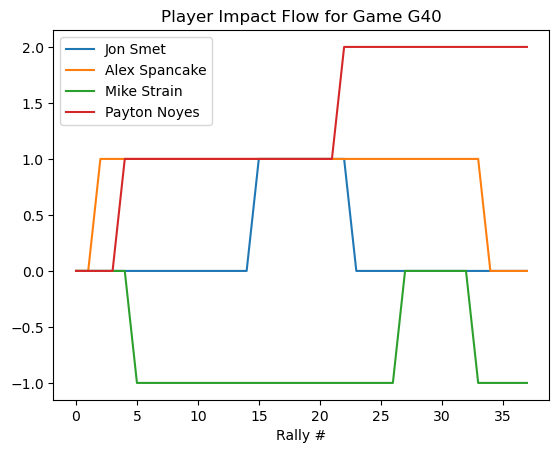

In [131]:
g.plot_impact_flow()

In [53]:
g.summarize_third_shots()

             Player  Drops %  Drives %  Lobs %  Total Thirds
       Jesse Irvine    94.12      5.88     0.0            17
Catherine Parenteau    75.00     25.00     0.0            12
  Anna Leigh Waters    75.00     25.00     0.0             4
       Leigh Waters    82.61     17.39     0.0            23


In [54]:
g.summarize_game()

Anna Leigh Waters & Leigh Waters beat Jesse Irvine & Catherine Parenteau 12-10 in game G1
             Player  Error %  Winner %
       Jesse Irvine    17.46      9.52
Catherine Parenteau     1.59      0.00
  Anna Leigh Waters     1.59      3.17
       Leigh Waters     9.52      4.76


In [8]:
g.rally.columns

Index(['rally_id', 'match_id', 'game_id', 'rally_nbr', 'srv_team_id',
       'srv_player_id', 'rtrn_team_id', 'rtrn_player_id', 'ts_player_id',
       'ts_type', 'w_team_id', 'to_ind', 'to_team_id', 'rally_len',
       'srv_switch_ind', 'rtrn_switch_ind', 'srv_team_flipped_ind',
       'rtrn_team_flipped_ind', 'ending_type', 'ending_player_id', 'lob_cnt',
       'dink_cnt', 'maint_dtm', 'maint_app', 'create_dtm', 'create_app'],
      dtype='object')

In [10]:
#| hide
import nbdev; nbdev.nbdev_export()